## Script to make the heatmap of cell denisty of any experiment

The script takes as input:
* import the dataframe and the pipette properties. They musy be stored in the same folder.
* set the size of the grid 

And gives as output:
* the heatmap of cell concentration.

The user must decide:
* if the colorbar should be in linear or log scale
* If the matrix should be in units of cells/um**2 or cell concentration/concentration background (unitless)

A gaussian blur is authomatically applied to the heatmap to smooth sharp concentration gradient. This feature can be removed by setting the variable "smoothing_factor" to 0


In [2]:
# import libraries
from tkinter import Tk
from tkinter.filedialog import askdirectory, askopenfilename
import os
import glob
import matplotlib.pyplot as plt
from matplotlib import path
import matplotlib
import matplotlib.colors as colors
%matplotlib inline 
import numpy as np
from progressbar import ProgressBar
import progressbar
import pandas as pd
import cv2 
import seaborn as sns
import pickle
import warnings
import json
from scipy import misc,ndimage
#suppress warnings
warnings.filterwarnings('ignore')
from ipynb.fs.full.my_functions import do_colormap, order_list
from ipynb.fs.full.my_functions import read_pipette_dictionary_json, read_pipette_dictionary_txt,  filter_cells_radius

sns.set_theme('poster') # paper, notebook, talk, poster
sns.set_style('ticks')


# conversion factor from pixel to um 
px_um_conversion_factor = 2.703

# image size: it is the same for all videos!
image_height, image_width = 720, 1280

# Some experiment have the file containing the capillary saved as json file and others as .txt. Select the file
# .txt or .json pipette file?
pipette_dictionary  = False # for .txt
json_pipette = True # for .json

#### Here give all the info needed: of which video we want the colormap, the directory where the files are (df and pipette properties) and where to save the outputs

In [13]:
# the DATAFRAME NAME MUST BE  in the format
#                                                    df_up + video_name
# and the PIPETTE FILE NAME MUST BE in the format 
#                                                   json_pipette_properties_2_ + video_name + .json

# example: if I have              df_up_G_D200_R2, 
#               and               json_pipette_properties_2_G_D200_R2.json
#               then              video_name = 'G_D200_R2'

# name of the video 
video_name = 'G_D200_R2'

In [5]:
# define the path where the data are stored. 
input_path = askdirectory()

In [6]:
# define the path where the data are stored. 
output_path = askdirectory()

In [9]:
### import pipette properties (needed to know where the center of the pipette is)
# select the pipette properties file to use 
if(pipette_dictionary):
    pipette_properties_dictionary  = read_pipette_dictionary_txt(input_path, video_name)

# WHIT JSON FILE
# with json
if(json_pipette):
    pipette_properties_dictionary  = read_pipette_dictionary_json(input_path, video_name)
    
x_center_pipette_up, y_center_pipette_up= pipette_properties_dictionary['x_center_upper_pipette'],  pipette_properties_dictionary['y_center_upper_pipette']# IN PIXEL!!!!!
x_center_pipette_low, y_center_pipette_low  = pipette_properties_dictionary['x_center_lower_pipette'], pipette_properties_dictionary['y_center_lower_pipette'] # IN PIXEL!!!!!
# order the x and y coordinates of the countour of the pipettes
x1, x2, x3, x4, y1, y2, y3, y4, list_x_up, list_y_up  = order_list(pipette_properties_dictionary['upper_contour'])# IN PIXEL!!!!!
x5, x6,  x7, x8, y5, y6,  y7, y8, list_x_low , list_y_low = order_list(pipette_properties_dictionary['lower_contour'])# IN PIXEL!!!!!

In [10]:
# distance between the pipette centers
# import df_up and df_low
with open(input_path+"/df_up_"+video_name + add_string_to_name + ".txt", "rb") as myFile:
        df_up = pickle.load(myFile)   
# create a column "frame"    
df_up.reset_index(level=0, inplace=True)

In [12]:
#Apply filter cells code
radius = 30 # --> max distance in PIXEL between different points in the trajectory to consider it stuck
n_frames = 30*10 # minimum number of frames the particle must remain stuck to be removed
df_up, black_list = filter_cells_radius(df_up, radius, n_frames)

detecting the cells which got stuck


100% |########################################################################|


dropping 0 out of 32179 trajectories: 0.00000 percent of trajectories


Set the suze of the grid in the colormap (in pixel). It should be a divisor of the size of the image (720x1280)

In [16]:
# get dimensions of the image 
x_grid_size = 16
y_grid_size = 8 

In [17]:
print('------------------------------------------------------------------------------------------------------')
print('COLORMAPS')
print('------------------------------------------------------------------------------------------------------')

print('calculating the matrix to do the colormap')


nx = int(image_width/x_grid_size) # number of grids on the x dimensions
ny = int(image_height/y_grid_size) # number of grids on the y dimensions

# initiate the matrix to zero
Z = np.zeros( (ny, nx)) # matrix for cell density 

# how many cells are in each grid 
# fill grid points over the y dimension
bar = ProgressBar(maxval=ny)
i = 0
j = 0

bar.start()
for i in range(0, ny): 
    # fill grid points over the x dimension: 
    for j in range(0, nx): 
        #print('(%i, %i)' %(i, j))
        cell_index = np.where( (df_up.x >=j*x_grid_size) & (df_up.x < (j+1)*x_grid_size) &  (df_up.y >= i*y_grid_size) & (df_up.y < (i+1)*y_grid_size))
        # count the cells per grid
        cell_number = np.size(cell_index)
        # add it to the matrix
        Z[i, j] = cell_number

    bar.update(i)

Z_copy = Z# I set a copy not to loose the original colormap if I want to try different calculations
# Pass the  values to concentrations: cells/um**2 
Z_concentration = Z_copy/(x_grid_size*y_grid_size*px_um_conversion_factor**2)
# apply a gaussian blur for a smoother results
smoothing_factor = 0.8
Z_concentration= ndimage.gaussian_filter(Z_concentration, smoothing_factor, mode='nearest')


# Calculate the average background concentration: also cells/px**2
Z_background = np.sum(Z)/(720*1280*px_um_conversion_factor**2)
# divide the colormap by the background
Z_normalized = Z_concentration/Z_background
Z = Z_normalized

------------------------------------------------------------------------------------------------------
COLORMAPS
------------------------------------------------------------------------------------------------------
calculating the matrix to do the colormap


Define the parameters of the colorbar: 
* give the maximum and minium values (automatically set to the max and min concentrations in the experiment) 
* decide the scale ("norm"): linear or log?

In [28]:
# Define the extremes of the colormap 
vmax = np.max(Z_concentration)# set colorbar max to the max value of the matrix Z 
#vmax = 0.02
vmin = np.min(Z_concentration) 

# logaritmic: good if the plotted field spans over different order of magnitude
norm=colors.LogNorm(vmin=vmin, vmax=vmax)
if( vmin == 0 ): 
    print('"vmin" cannot be zero in log scale, change vmin to a positive value if you want to use the log scale')

# linear scale 
norm=colors.Normalize(vmin = vmin, vmax = vmax)

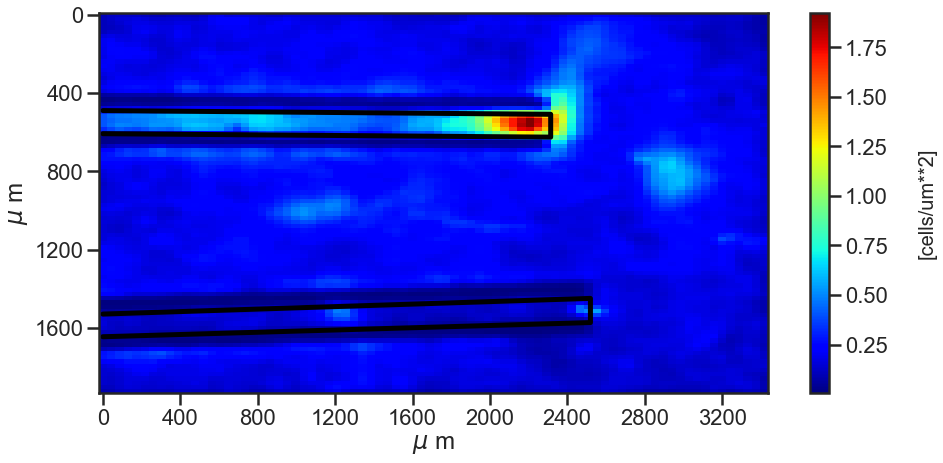

In [29]:
#plot
fig, ax = plt.subplots(figsize=(15, 7))

mesh = ax.pcolormesh(np.arange(0,image_width, x_grid_size), np.arange(0,image_height, y_grid_size), Z_concentration, norm = norm, 
                     cmap = 'jet', shading = 'auto') # if you want to remove the log scale, remove the param "norm" from pcolormesh
cbar = fig.colorbar(mesh)
cbar.set_label('[cells/um**2]', rotation=90, labelpad=30, fontsize = 20)

#cbar.set_label(r'number of cells / (%i x % i) pixel$^2$' %(x_grid_size,y_grid_size), fontsize = 15)
plt.plot(list_x_up, list_y_up, color = 'black', linewidth = 5)
plt.plot(list_x_low, list_y_low, color = 'black', linewidth = 5)

x_ticks_position_um= np.arange(0, image_width*px_um_conversion_factor, 400)
x_ticks_position_px = x_ticks_position_um/px_um_conversion_factor
x_ticks_position_um_label = [int(i) for i in x_ticks_position_um]
ax.set_xticks(ticks = x_ticks_position_px)
ax.set_xticklabels(labels= x_ticks_position_um_label)
ax.set_xlabel('$\mu$ m')


y_ticks_position_um= np.arange(0, image_height*px_um_conversion_factor, 400)
y_ticks_position_px = y_ticks_position_um/px_um_conversion_factor
y_ticks_position_um_label = [int(i) for i in y_ticks_position_um]
ax.set_yticks(ticks = y_ticks_position_px)
ax.set_yticklabels(labels= y_ticks_position_um_label)
ax.set_ylabel('$\mu$ m')

#ax.set_xlim([0, 2800/px_um_conversion_factor])


plt.gca().invert_yaxis()

#fig.savefig(output_path + '/'+video_name+'_colormap')
# plt.close(fig); # comment this if you want to see the picture displayed while running the script 